<a href="https://colab.research.google.com/github/AlexandreNap/hack_zzccmxtp/blob/main/lezgongue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir data_wav/

In [ ]:
!unzip /content/gdrive/MyDrive/data_wav.zip -d data_wav/

In [120]:
!mkdir data_wav2/

In [ ]:
!unzip /content/gdrive/MyDrive/data_wav2.zip -d data_wav2/

In [2]:
import numpy as np
import pandas as pd
from scipy.io import wavfile
import scipy
from tqdm import tqdm

In [3]:
ls

data_wav/  data_wav2/  gdrive/  graph.pdf  sample_data/


In [4]:
#for mp3 to wav, in windows shell i did: for %i in (data\\*.mp3) do ffmpeg -i "%i" "data_wav\\%~ni.wav"

In [5]:
CORR_THRESHOLD = 0.4

SAMPLERATE = 16000

In [6]:
path = "./data_wav2/data_wav/"# zzccmxtp_all/"

In [7]:
from os import listdir
from os.path import isfile, join

onlyfiles = [f for f in listdir(path)]
print(len(onlyfiles))

832


In [136]:
import os

for i, name in enumerate(onlyfiles):
    i_str = str(i)
    new_name = (5*"0")[:5-len(i_str)] + i_str + "_" + name
    os.rename(path + name, path + new_name)


In [8]:
from scipy.io import wavfile
import scipy.signal as sps

onlyfiles = [f for f in listdir(path)]
onlyfiles.sort()
print(len(onlyfiles))

sounds_list = []
for file in tqdm(onlyfiles):
    samplerate, data = wavfile.read(join(path, file))
    number_of_samples = round(len(data) * float(SAMPLERATE) / samplerate)
    data = sps.resample(data, number_of_samples)
    sounds_list.append({"name": file,
                        "data": np.array(data)})
sounds_df = pd.DataFrame(sounds_list)

832


100%|██████████| 832/832 [00:47<00:00, 17.44it/s]


In [9]:
sounds_df.data

0      [[3213.117394445943, 2598.610076307575], [-944...
1      [[489.4963358839536, 2362.5281903264117], [-12...
2      [[3580.6686667850563, 3655.156483831497], [-87...
3      [[1119.0085198672823, -565.3997993121143], [-2...
4      [[5365.789101781244, 4007.924761618456], [-122...
                             ...                        
827    [[325.8377053203236, 82.68367837560955], [63.1...
828    [[-6851.931274389427, -8461.963653893941], [16...
829    [[1243.315871582406, 3839.344673287422], [-536...
830    [[-471.24743443038784, 335.49516432549404], [1...
831    [[-3542.7789596546445, -2456.6186117765983], [...
Name: data, Length: 832, dtype: object

In [10]:
sounds_df.data = sounds_df.data.apply(lambda x: x.sum(axis=1) / x.shape[1])

In [11]:
sounds_df.name

0      00000_1536753961784561670_1.wav
1      00001_1536744911701217283_1.wav
2      00002_1536753461584449536_1.wav
3      00003_1536663589188247554_1.wav
4      00004_1536717068573229057_1.wav
                    ...               
827    00827_1536747202189705216_1.wav
828    00828_1536790748896677894_1.wav
829    00829_1536653853407453187_1.wav
830    00830_1536725975823798276_1.wav
831    00831_1536720989597356032_1.wav
Name: name, Length: 832, dtype: object

In [12]:
sounds_df.data

0      [2905.863735376759, -865.0988810348615, 528.54...
1      [1426.0122631051827, -315.71288241301045, 159....
2      [3617.9125753082767, -886.6249231465936, 481.6...
3      [276.804360277584, -81.63248039419811, 45.4093...
4      [4686.85693169985, -1051.758726840896, 535.847...
                             ...                        
827    [204.26069184796657, -6.721825910307281, -14.4...
828    [-7656.947464141684, 1805.0115418639411, -954....
829    [2541.330272434914, -788.1874619001188, 480.69...
830    [-67.8761350524469, 20.874705802021424, -11.90...
831    [-2999.6987857156214, 749.4835509146585, -412....
Name: data, Length: 832, dtype: object

In [18]:
from scipy.fft import fft
import matplotlib.pyplot as plt

sounds_df['fft'] = sounds_df.data.apply(lambda x: np.abs(fft(x)[:]))

In [19]:
fft_list = sounds_df['fft'].tolist()

In [174]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
X = np.array(fft_list)
X = (X - X.mean(axis=0))# / X.std(axis=0)
pca.fit(X)

PCA(n_components=20)

In [175]:
pca.explained_variance_ratio_

array([0.22397107, 0.08829201, 0.0567813 , 0.04091863, 0.03382465,
       0.02928013, 0.02453803, 0.02420236, 0.02077434, 0.01863495,
       0.0181376 , 0.01541606, 0.01318069, 0.0125554 , 0.01190037,
       0.01076991, 0.00978514, 0.00879229, 0.00853927, 0.00806528])

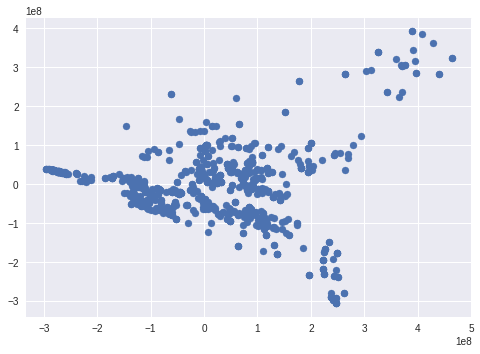

In [176]:
X2 = pca.transform(X)
plt.scatter(X2[:,0],X2[:,1])

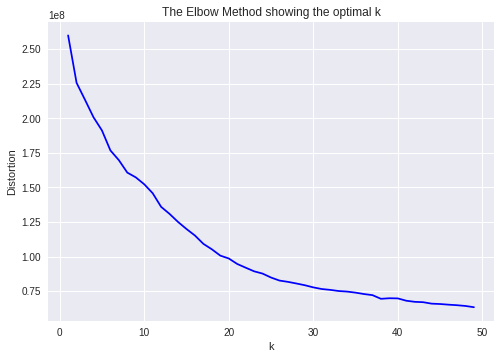

In [177]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

kX = X2
distortions = []
K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(kX)
    kmeanModel.fit(kX)
    distortions.append(sum(np.min(cdist(kX, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / kX.shape[0])
    
# Plot the elbow curve
plt.style.use('seaborn')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [178]:
linear = []
ld = len(distortions)
steep = (distortions[ld-1] - distortions[0]) / (ld - 1)
c = distortions[ld-1] - steep * ld
for x in range(0,ld):
    linear.append(steep * (x+1) + c)
    
distances = np.array(linear)-np.array(distortions)
max_index = distances.argmax(axis=0)+1

In [179]:
max_index

19

In [180]:
kmeanModel = KMeans(n_clusters=max_index).fit(kX)
classes_pred = kmeanModel.fit_predict(kX)

In [181]:
sounds_df['kmeans_pred'] = classes_pred

In [182]:
length = len(sounds_df.data.values[0])

In [183]:
sounds_df.kmeans_pred.value_counts()

8     105
4      96
1      88
10     86
14     54
11     42
16     42
12     40
9      36
7      34
5      32
0      31
2      31
15     30
6      28
3      22
13     18
17     12
18      5
Name: kmeans_pred, dtype: int64

In [138]:
sounds_df.kmeans_pred.value_counts()

6    344
1    210
0    131
4     41
7     32
5     31
3     30
2     13
Name: kmeans_pred, dtype: int64

In [198]:
%%time

from scipy import signal
corr_tab = np.zeros([len(sounds_df), len(sounds_df)])
argmax_corr_shift = np.zeros([len(sounds_df), len(sounds_df)])
max_corr_shift = np.zeros([len(sounds_df), len(sounds_df)])

sounds_df["stded_data"] = sounds_df.data.apply(lambda x: np.array(x) / np.array(x).std()) 


for i in range(len(sounds_df)):
    for j in range(i,len(sounds_df)):
        if sounds_df.kmeans_pred.values[i] == 3 and\
        sounds_df.kmeans_pred.values[j] == 3 and\
        i!=j:
            corr = signal.correlate(sounds_df.stded_data.values[i], sounds_df.stded_data.values[j], "full", "fft")/ length
            
            corr_tab[i, j] = corr.max()
            corr_tab[j, i] = corr.max()

            shift =  (length - corr.argmax())/SAMPLERATE
            
            argmax_corr_shift[i, j] = shift
            argmax_corr_shift[j, i] = shift
            shift = np.abs(shift)
            #if (0.97 < np.abs(shift) < 1.03):
            #  break

CPU times: user 6.48 s, sys: 1.3 s, total: 7.78 s
Wall time: 7.83 s


In [199]:
edges = [[x,y] for x,y in np.argwhere(corr_tab>0.3) if x < y]

In [200]:
len(edges)

215

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., 20.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0., 21.,  0.,  0.,  9., 17.,  8.,  0.,  0.,  0.,
         6., 29.,  0.,  0.,  0., 14., 13.,  3.,  0.,  0.,  5., 38.,  0.,
         0.,  0.,  0., 16.,  0.,  0.,  0.,  4., 12.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.]),
 array([-4.00000000e+00, -3.90000000e+00, -3.80000000e+00, -3.70000000e+00,
        -3.60000000e+00, -3.50000000e+00, -3.40000000e+00, -3.30000000e+00,
        -3.20000000e+00, -3.10000000e+00, -3.00000000e+00, -2.90000000e+00,
        -2.80000000e+00, -2.70000000e+00, -2.60000000e+00, -2.50000000e+00,
        -2.40000000e+00, -2.30000000e+00, -2.20000000e+00, -2.10000000e+00,
        -2.00000000e+00, -1.90000000e+00, -1.80000000e+00, -1.70000000e+00,
        -1.60000000e+00, -1.50000000e+00, -1.40000000e+00, -1.30000000e+00,
        -1

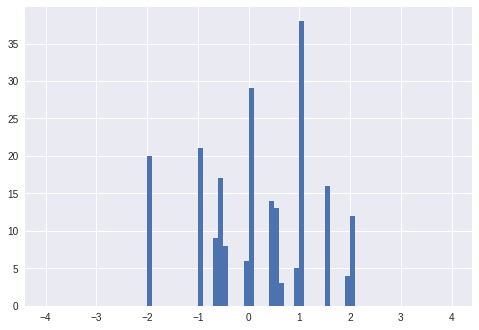

In [201]:
binwidth = 0.1
plt.hist([argmax_corr_shift[edge[0], edge[1]] for edge in edges], bins=np.arange(-4, 4 + binwidth, binwidth))

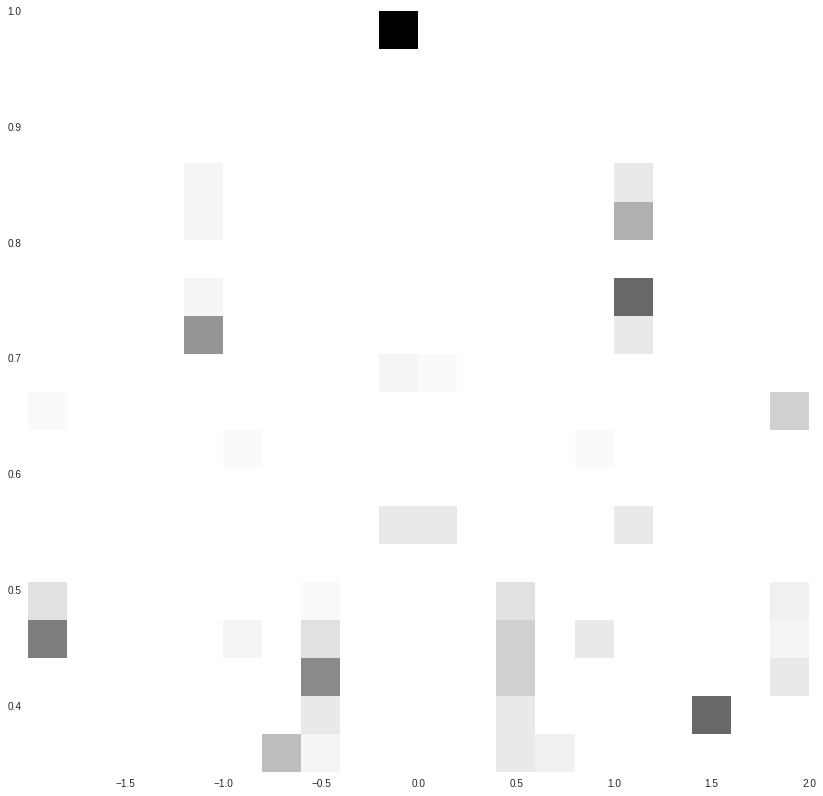

In [202]:
plt.figure(figsize=(14,14))
plt.hist2d([argmax_corr_shift[edge[0], edge[1]] for edge in edges], [corr_tab[edge[0], edge[1]] for edge in edges], bins=20) 
plt.show()

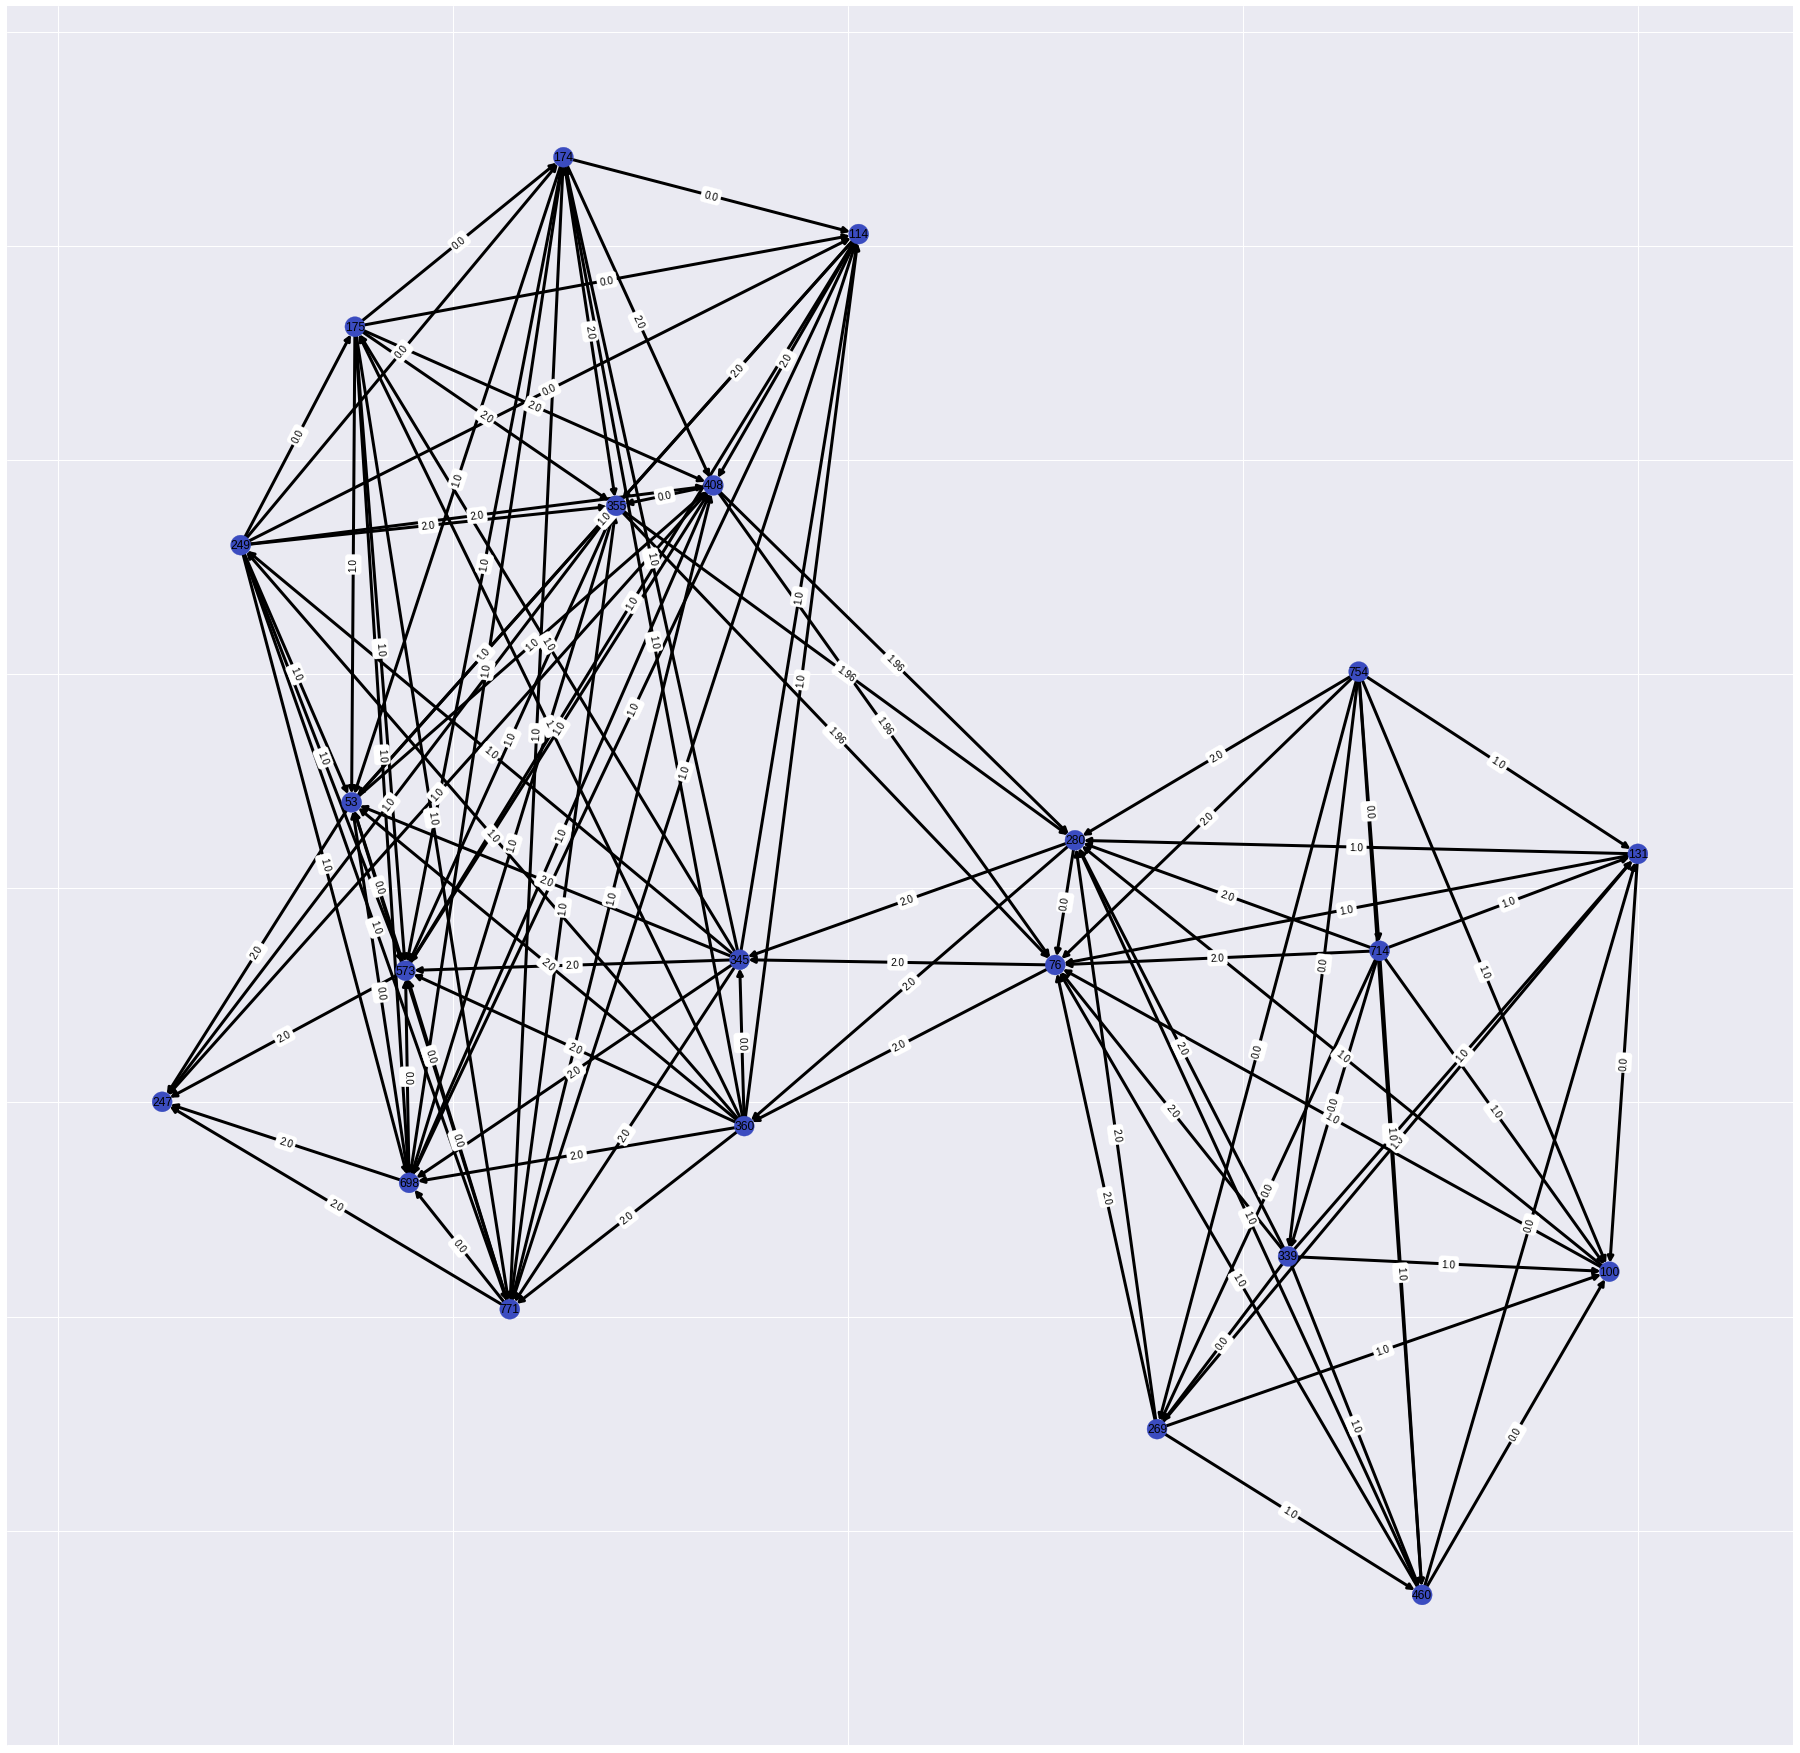

In [203]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams

G = nx.DiGraph(directed=True)
#for i in range(len(sounds_df)):
#    G.add_nodes_from([i])
for edge in edges:
  
    G.add_nodes_from(edge)
    shift = argmax_corr_shift[edge[0], edge[1]]
    if (np.abs(shift) <.02) or\
      (0.97 < np.abs(shift) < 1.03) or\
      (1.95 < np.abs(shift) < 2.05) or\
      (2.9 < np.abs(shift) < 3.1):
        if shift>0: # start0 > start1
            G.add_edges_from(
                [(edge[1], edge[0])], 
                weight=4-shift)
        else: # start0 <= start1
            G.add_edges_from(
                [(edge[0], edge[1])], 
                weight=4+shift)

#double nodes cleaning
for edge in edges:#false everytime
    if 1==2 and list(sounds_df.data.values[edge[0]]) == list(sounds_df.data.values[edge[1]]):
        if (edge[0], edge[1]) in nx.edges(G):
            G.remove_edge(edge[0], edge[1])
        if (edge[1], edge[0]) in nx.edges(G):
            G.remove_edge(edge[1], edge[0])
        # G.remove_node(edge[1])


options = {
    'width': 3,
    'arrowstyle': '-|>',
    'arrowsize': 12,
}
plt.figure(figsize=(32,32)) 
pos=nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos,arrows=True, **options)

labels = dict()
for key, value in nx.get_edge_attributes(G,'weight').items():
    labels[key] = str(round(4 - value, 2))

color_lookup = {k:v for k, v in zip(np.arange(len(sounds_df)), sounds_df.kmeans_pred.tolist()) if k in G.nodes}
low, *_, high = sorted(color_lookup.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)


nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
nx.draw_networkx_nodes(G, pos, nodelist=color_lookup,
                       node_size=400,
                       node_color=[mapper.to_rgba(i) for i in color_lookup.values()])
#plt.show()
plt.savefig('graph.png')

In [204]:
import plotly.express as px
fig = px.imshow(corr_tab)
fig.show()

# test 2 signals

In [193]:
sounds_df[sounds_df.kmeans_pred==4].name

6      00006_1536794237324386311_1.wav
16     00016_1536761305641664512_1.wav
29     00029_1536754900494913536_1.wav
35     00035_1536683052600070144_1.wav
58     00058_1536793666702000130_1.wav
                    ...               
753    00753_1536717849938509825_1.wav
760    00760_1536717702856904704_1.wav
765    00765_1536751173365112832_1.wav
772    00772_1536716647494520832_1.wav
773    00773_1536729740177965057_1.wav
Name: name, Length: 96, dtype: object

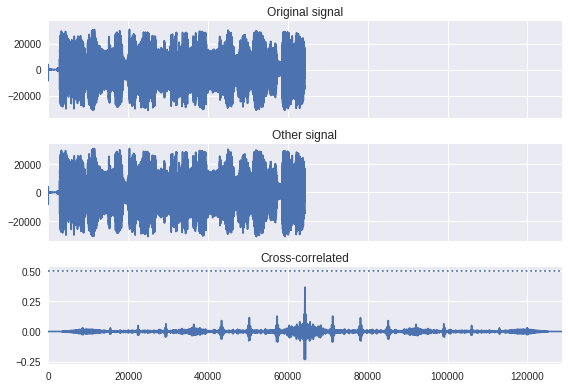

In [205]:
id1 = 174
id2 = 114

sig1 = np.array(sounds_df.data.values[id1])
sig2 = np.array(sounds_df.data.values[id2])

corr = signal.correlate(sig1/sig1.std(), sig2/sig2.std()) / 175040
clock = np.arange(0, 175040)
fig, (ax_orig, ax_orig2, ax_corr) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(sig1)
ax_orig.set_title('Original signal')
ax_orig2.plot(sig2)
ax_orig2.set_title('Other signal')
ax_corr.plot(corr)
ax_corr.axhline(0.5, ls=':')
ax_corr.set_title('Cross-correlated')
ax_orig.margins(0, 0.1)
fig.tight_layout()
plt.show()

In [206]:
print((length - corr.argmax())/SAMPLERATE) # time start sig1 - time start sig2
print(corr.max())

6.25e-05
0.3671905969560119


In [207]:
from IPython.display import Audio
Audio(path +"/"+ sounds_df.name.values[id1], rate=44100)

In [208]:
Audio(path +"/"+ sounds_df.name.values[id2], rate=44100)